<a href="https://colab.research.google.com/github/ArtemAvanesov/Roonyx-Labs/blob/master/5_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
from sklearn.metrics import classification_report
from tensorflow.random import set_seed
import random
from keras import layers
from keras.layers import Dropout
from keras import models
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from scipy import ndimage
import pandas as pd
import shutil
import cv2
import os

import warnings
warnings.filterwarnings('ignore')

# Read and unzip data

In [0]:
base_dir = '/content/drive/My Drive/Colab/Roonyx/work_5'
zip_path = base_dir + '/leaf_diseases.zip'
unzip_path = base_dir + '/dataset'

!mkdir '$unzip_path'
!unzip -d '$unzip_path' '$zip_path'

# Examples of input data

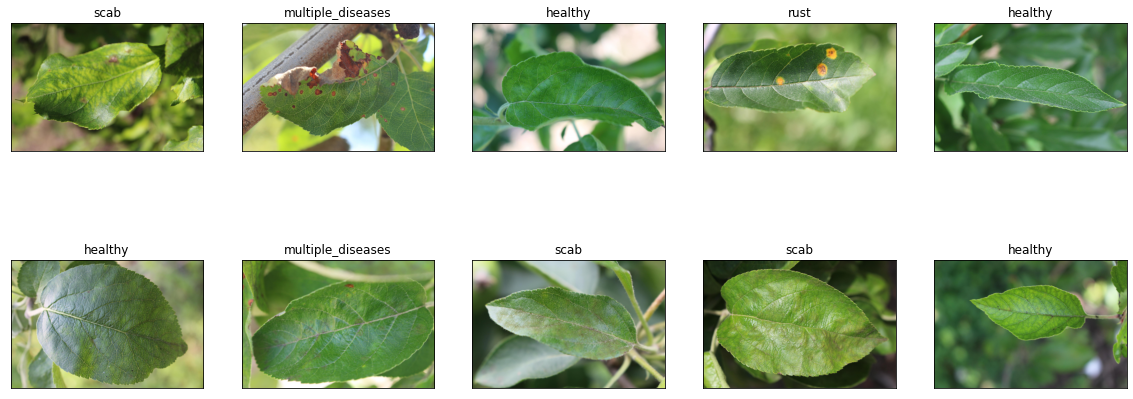

In [4]:
leafs = pd.read_csv(unzip_path+'/plant-pathology-2020-fgvc7/train.csv') 
y = np.array(leafs.drop(["image_id"], axis=1).values)

example_images = []
labels_example_images = []

for i in range(0,10,1):
  img = cv2.imread("/content/drive/My Drive/Colab/Roonyx/work_5/dataset/plant-pathology-2020-fgvc7/images/Train_{}.jpg".format(i))
  example_images.append(img)
  if y[i][0]==1: 
    labels_example_images.append("healthy")
  elif y[i][1]==1: 
    labels_example_images.append("multiple_diseases")
  elif y[i][2]==1: 
    labels_example_images.append("rust")
  elif y[i][3]==1: 
    labels_example_images.append("scab")

fix,axes = plt.subplots(2,5, figsize=(20,8), subplot_kw={'xticks':(),'yticks':()})
for name, image, ax in zip(labels_example_images, example_images, axes.ravel()):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax.imshow(image, cmap=plt.cm.binary)
    ax.set_title(name)

# Plotting class distribution histogram

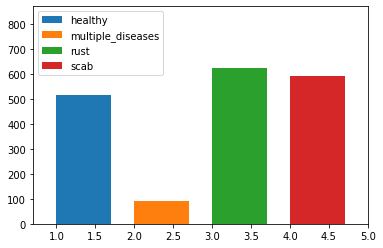

In [5]:
num_healthy = sum(y[:,0])
num_multiple_diseases = sum(y[:,1])
num_rust = sum(y[:,2])
num_scab = sum(y[:,3])

plt.hist([1]*num_healthy,bins=4, label = "healthy", width = 0.7)
plt.hist([2]*num_multiple_diseases,bins=4, label = "multiple_diseases", width = 0.7)
plt.hist([3]*num_rust,bins=4, label = "rust", width = 0.7)
plt.hist([4]*num_scab,bins=4, label = "scab", width = 0.7)
plt.ylim(0,max(num_healthy,num_multiple_diseases,num_rust, num_scab)*1.4)
plt.xlim(0.7,5)
plt.legend(loc='best')

# Adding data for second class

In [0]:
def generate_new_leafs(image):
    
    new_images = []
    new_images.append(cv2.flip(image,0))
    new_images.append(ndimage.rotate(image, 90))
    new_images.append(cv2.flip(image,1))
    new_images.append(ndimage.rotate(image, 180))
    new_images.append(ndimage.rotate(image, 270))
    
    labels = ['vertical reflection', 'rotated 90 degrees', 'horizontal reflection', 'rotated 180 degrees', 'rotated 270 degrees']
    
    return new_images, labels

## Example of adding data for second class

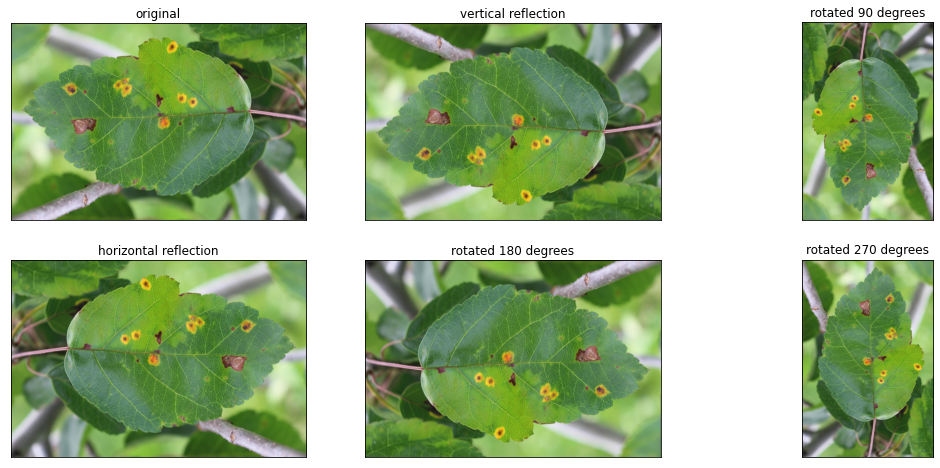

In [7]:
image = cv2.imread("/content/drive/My Drive/Colab/Roonyx/work_5/dataset/plant-pathology-2020-fgvc7/images/Train_338.jpg")
new_images, new_labels = generate_new_leafs(image)

images = [image] + new_images
labels = ['original'] + new_labels

fix,axes = plt.subplots(2,3, figsize=(18,8), subplot_kw={'xticks':(),'yticks':()})
for img, label, ax in zip(images, labels, axes.ravel()):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img, cmap=plt.cm.binary)
    ax.set_title(label)

## Adding generated data

In [0]:
max_id = len(y)
cur_id = max_id

f = open(unzip_path + "/plant-pathology-2020-fgvc7/train.csv", 'a')

for i in range(0,max_id,1):
  if y[i][1] == 1:
    image = cv2.imread(unzip_path+ "/plant-pathology-2020-fgvc7/images/Train_{}.jpg".format(i))
    images,_ = generate_new_leafs(image)
    for img in images:
      cv2.imwrite(unzip_path+ "/plant-pathology-2020-fgvc7/images/Train_{}.jpg".format(cur_id), img)
      f.write("Train_{},0,1,0,0\n".format(cur_id))
      y = np.append(y,[[0,1,0,0]], 0)
      cur_id += 1

f.close()

# Plotting class distribution histogram after adding images

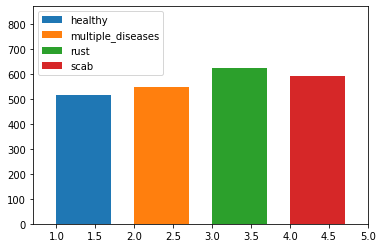

In [0]:
num_healthy = sum(y[:,0])
num_multiple_diseases = sum(y[:,1])
num_rust = sum(y[:,2])
num_scab = sum(y[:,3])

plt.hist([1]*num_healthy,bins=4, label = "healthy", width = 0.7)
plt.hist([2]*num_multiple_diseases,bins=4, label = "multiple_diseases", width = 0.7)
plt.hist([3]*num_rust,bins=4, label = "rust", width = 0.7)
plt.hist([4]*num_scab,bins=4, label = "scab", width = 0.7)
plt.ylim(0,max(num_healthy,num_multiple_diseases,num_rust, num_scab)*1.4)
plt.xlim(0.7,5)
plt.legend(loc='best')

# Splitting data

## Creating directories for train, test, validation

In [0]:
splitted_dataset_path = base_dir + '/splitted_dataset'
os.mkdir(splitted_dataset_path)

train_dir = os.path.join(splitted_dataset_path, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(splitted_dataset_path, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(splitted_dataset_path, 'test')
os.mkdir(test_dir)

for path in [train_dir, test_dir, validation_dir]:
  for num_class in [0,1,2,3]:
    class_dir = os.path.join(path, str(num_class) + '_class')
    os.mkdir(class_dir)

## Search image indexes for each class

In [0]:
indices_class_0, indices_class_1, indices_class_2, indices_class_3 = [], [], [], []
for i in range(0, len(y),1):
  if(np.argmax(y[i]) == 0):
    indices_class_0.append(i)
  elif(np.argmax(y[i]) == 1):
    indices_class_1.append(i)
  elif(np.argmax(y[i]) == 2):
    indices_class_2.append(i)
  elif(np.argmax(y[i]) == 3):
    indices_class_3.append(i)

## Shuffling Index Arrays

In [0]:
seed = 42
np.random.seed(seed)
set_seed(seed)

random.shuffle(indices_class_0)
random.shuffle(indices_class_1)
random.shuffle(indices_class_2)
random.shuffle(indices_class_3)

indices_classes = [indices_class_0, indices_class_1, indices_class_2, indices_class_3]

## Calculation num of elements in test, train and validation samples

In [0]:
percent_validation = 15
percent_test = 15

num_test = []
num_validation = []
num_train = []
for i in range(0,4,1):
  num_test.append(int(len(indices_classes[i])*percent_test/100))
  num_validation.append(int(len(indices_classes[i])*percent_validation/100))
  num_train.append(len(indices_classes[i])-num_test[-1] - num_validation[-1])

array_for_pandas = np.transpose([num_train, num_validation, num_test])

df = pd.DataFrame({
     '': ['Train', 'Validation', 'Test'],
     'Class 0': array_for_pandas[0,:],
     'Class 1': array_for_pandas[1,:],
     'Class 2': array_for_pandas[2,:],
     'Class 3': array_for_pandas[3,:]
 })

df

,,Class 0,Class 1,Class 2,Class 3
0,Train,362,384,436,416
1,Validation,77,81,93,88
2,Test,77,81,93,88


## Writing data with train, test and validation samples

In [0]:
src = unzip_path + '/plant-pathology-2020-fgvc7/images'

# For test images
for num_class in [0,1,2,3]:
  test_fnames = ['Train_{}.jpg'.format(i) for i in indices_classes[num_class][0:num_test[num_class]]]
  for fname in test_fnames:
    shutil.copyfile(src+'/'+fname, test_dir+'/'+str(num_class)+'_class'+'/'+fname)

# For validation images 
for num_class in [0,1,2,3]:
  validation_fnames = ['Train_{}.jpg'.format(i) for i in indices_classes[num_class][num_test[num_class]:num_test[num_class] + num_validation[num_class]]]
  for fname in validation_fnames:
    shutil.copyfile(src+'/'+fname, validation_dir+'/'+str(num_class)+'_class'+'/'+fname)

# For train images
for num_class in [0,1,2,3]:
  train_fnames = ['Train_{}.jpg'.format(i) for i in indices_classes[num_class][num_test[num_class] + num_validation[num_class]:]]
  for fname in train_fnames:
    shutil.copyfile(src+'/'+fname, train_dir+'/'+str(num_class)+'_class'+'/'+fname)

# Preprocessing data

In [0]:
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=100,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=100,
        class_mode='categorical')

test_generator=test_datagen.flow_from_directory(
        test_dir,
        target_size=(150,150),
        batch_size=100,
        class_mode='categorical')

Found 1598 images belonging to 4 classes.
Found 339 images belonging to 4 classes.
Found 339 images belonging to 4 classes.


# Model of Convolutional Neural Network


In [0]:
def my_net(dropout=False , dropout_value = 0.0):

  model = models.Sequential()

  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  if dropout:
    model.add(Dropout(dropout_value))

  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  if dropout:
    model.add(Dropout(dropout_value))

  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  if dropout:
    model.add(Dropout(dropout_value))

  model.add(layers.Conv2D(256, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  if dropout:
    model.add(Dropout(dropout_value))

  model.add(layers.Conv2D(256, (3, 3), activation='relu'))
  model.add(layers.Flatten())
  if dropout:
    model.add(Dropout(dropout_value))

  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(4, activation='softmax'))

  return model

# Neural network without dropout

In [0]:
model = my_net()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 256)      

## Neural network training

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
              train_generator,
              steps_per_epoch=sum(num_train)//100,
              epochs=30,
              validation_data=validation_generator,
              validation_steps=sum(num_validation)//100)

## Accuracy and loss

In [0]:
plt.figure(figsize=(10,3))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Neural network with dropout

In [0]:
model_array = []
dropout_array = [0.5, 0.6, 0.7]
for dropout_value in dropout_array:
  model_array.append(my_net(dropout=True, dropout_value=dropout_value))

model_array[0].summary()

## Neural network training

In [0]:
history_array = []
for model_nn in model_array:
  model_nn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  history_array.append(model_nn.fit(
                train_generator,
                steps_per_epoch=sum(num_train)//100,
                epochs=10,
                validation_data=validation_generator,
                validation_steps=sum(num_validation)//100))

## Accuracy and loss

In [0]:
for i in range (0,len(history_array),1):

  plt.figure(figsize=(10,3))

  plt.subplot(1, 2, 1)
  plt.plot(history_array[i].history['accuracy'])
  plt.plot(history_array[i].history['val_accuracy'])
  plt.title('Model accuracy (dropout = {})'.format(dropout_array[i]))
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.ylim(0.2,0.6)
  plt.legend(['Train', 'Test'], loc='upper left')

  plt.subplot(1, 2, 2)
  plt.plot(history_array[i].history['loss'])
  plt.plot(history_array[i].history['val_loss'])
  plt.title('Model loss (dropout = {})'.format(dropout_array[i]))
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.ylim(1.1,1.5)
  plt.legend(['Train', 'Test'], loc='upper left')

# Metrics on the best model

In [0]:
index_best_model = 2
# best_model = model_array[index_best_model]
best_model = model

preds = np.array([])
y_true = np.array([])

for _ in range(len(test_generator)):
  images, labels = test_generator.next()
  pred = best_model.predict(images)
  preds = np.concatenate((preds, np.argmax(pred, axis=1)))
  y_true = np.concatenate((y_true, np.argmax(labels, axis=1)))

print(classification_report(y_true, preds, target_names=['healthy', 'multiple_diseases', 'rust', 'scab']))

# Feature maps of the best model

In [0]:
imgs,labels = train_generator.next()
img = imgs[:1]

num_in_row = 8

names = []
outputs = []

for layer in best_model.layers:
  if 'conv' in layer.name:
    outputs.append(layer.output)
    names.append(layer.name)

model2 = Model(inputs = best_model.inputs, outputs=outputs)

feature_maps = model2.predict(img)
for feature_maps, l_name in zip(feature_maps, names):
  fmap = np.transpose(feature_maps[0], axes = [2,1,0])
  fig, axes = plt.subplots(int(len(fmap)/num_in_row), num_in_row, figsize = (16, 2*int(len(fmap)/num_in_row)), subplot_kw={'xticks':(), 'yticks':()})
  fig.suptitle(l_name, fontsize = 40)

  for image, ax in zip(fmap, axes.ravel()):
    ax.imshow(image)